In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook as tqdm
import torch
from torch.autograd import Variable, grad
from torch.nn.functional import binary_cross_entropy_with_logits as bce
import os
import imageio

# Conditional GAN learning to sample from Gaussian with given mean.

Conditional GAN implementation that produces Gaussian values around a given mean. Tested to see if values around a mean that the GAN was not trained on could be generated. See below for results on quick training of 3000 epochs.

Adapted from some base code given by Dr. David Lopez-Paz for another modeling question.

In [41]:
class Perceptron(torch.nn.Module):
    def __init__(self, sizes, final=None):
        super(Perceptron, self).__init__()
        layers = []
        for i in range(len(sizes) - 1):
            layers.append(torch.nn.Linear(sizes[i], sizes[i + 1]))
            if i != (len(sizes) - 2):
                if Layer_type == 'LeakyReLU':
                    layers.append(torch.nn.LeakyReLU())
                else:
                    layers.append(torch.nn.ReLU())
        if final is not None:
            layers.append(final())
        self.net = torch.nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


def plot(x, y, epoch):
    real = x.cpu().data.numpy()
    fake = y.cpu().data.numpy()
    
    for i in range(len(real[:,0])):
        if i % 500 == 0:
            # to see if there is any difference in the x values for different means, there doesn't seem to be
            print "Difference in generated values for the two means: ", fake[0,:], fake[1000,:]
        break
        
    lims = (x.data.min() - 0.1, x.data.max() + 0.1)
    fig, (ax1,ax2) = plt.subplots(ncols = 2, figsize=(6, 3))
    ax1.plot(real[:, 0], real[:, 1], '.', label='real')
    ax1.plot(fake[:, 0], fake[:, 1], '.', alpha=0.25, label='fake')
    plt.axis('on')
    plt.gca().axes.get_xaxis().set_visible(True)
    plt.gca().axes.get_yaxis().set_visible(True)
    plt.xlim(*lims)
    plt.ylim(*lims)
    plt.tight_layout(0, 0, 0)
    ax2.hist(real[:,0], label = 'real', bins = np.arange(-4, 14, 0.4))
    ax2.hist(fake[:,0], label = 'fake', alpha = 0.25, bins = np.arange(-4, 14, 0.4))
    ax2.set_ylim(0,(len(real[:,1]) / 3))
    fig.subplots_adjust(wspace=.2)
    plt.title("Epoch " + str(epoch + 2000))
    epoch = epoch
    plt.savefig("./plots/GIFTest/Epoch" + str(epoch) + ".png")
    plt.show()


def sample_real(n, shape, conditional_means = [0,10]):
    n_per_mean = n / len(conditional_means)
    sample_vals = []
    sample_means = []
    for mean in conditional_means:
        sample_vals.extend(np.random.normal(loc = mean, size = n_per_mean))
        sample_means.extend(np.full(n_per_mean, mean))
    if len(sample_means) < n:
        sample_means.extend(np.full((n - len(sample_means)), mean))
        sample_vals.extend(np.random.normal(loc = mean, size = (n - len(sample_vals))))
    s = np.column_stack((sample_vals, sample_means))
    sample_means = np.array(sample_means).reshape(len(sample_means), 1)
    sample_vals = np.array(sample_vals).reshape(len(sample_vals), 1)
    return (Variable(torch.FloatTensor(sample_vals)), 
            Variable(torch.Tensor(sample_means)),
            Variable(torch.FloatTensor(s)))


def sample_noise(bs, d, conditional_means = [0,10]):
    #z_vals = np.random.uniform(low = 5, high = 6,size=(bs,1))
    z_vals = np.random.normal(loc=0, size=(bs,1))
    n_per_mean = bs / len(conditional_means)
    means = []
    for mean in conditional_means:
        means.extend(np.full(n_per_mean, mean))
    if len(means) < bs:
        means.extend(np.full((bs - len(means)), mean))
    z = np.column_stack((z_vals, means))
    return Variable(torch.FloatTensor(z_vals)), Variable(torch.FloatTensor(z))



In [6]:
n_iterations = 3000
n_latent = 2
n_layers = 4
n_hidden = 20
bs = 10
conditional_means = [0, 5, 10]
shape = 'gaussian'
lamD = 50.
extraD = 15
wgan = True
verbose = True
v_freq = 50
Layer_type = 'ReLU'
MakeGif = True

netD = Perceptron([2] + [n_hidden] * n_layers + [1])
netG = Perceptron([n_latent] + [n_hidden] * n_layers + [1])
print netG
optD = torch.optim.SGD(netD.parameters(), lr = 1e-3)
optG = torch.optim.Adam(netG.parameters())

p_real, p_means, p_both_real = sample_real(2000, shape, conditional_means)
print p_real.data.numpy().shape, p_means.data.numpy().shape
p_nois, p_noise_and_means = sample_noise(2000, 1, conditional_means)
print p_nois.data.numpy().shape

Perceptron (
  (net): Sequential (
    (0): Linear (2 -> 20)
    (1): ReLU ()
    (2): Linear (20 -> 20)
    (3): ReLU ()
    (4): Linear (20 -> 20)
    (5): ReLU ()
    (6): Linear (20 -> 20)
    (7): ReLU ()
    (8): Linear (20 -> 1)
  )
)
(2000, 1) (2000, 1)
(2000, 1)


In [7]:
def objective_wgan(fakeD, realD):
    return fakeD.mean() - realD.mean()


def objective_gan(fakeD, realD):
    
    labD = torch.cat((torch.ones(fakeD.size(0), 1) - 1e-3,
                      torch.zeros(realD.size(0), 1) + 1e-3))
    return bce(torch.cat((fakeD, realD)), Variable(labD))

Are the D gradients small?  Variable containing:
 0.2590
 0.1690
[torch.FloatTensor of size 2]

Is the G loss small?  Variable containing:
1.00000e-02 *
  3.0449
[torch.FloatTensor of size 1]

Epoch #1: Generative Loss: 0.0304486751556, Discriminative Loss: -0.0630989074707
Difference in generated values for the two means:  [ 0.34761554  0.        ] [ 4.48038292  5.        ]


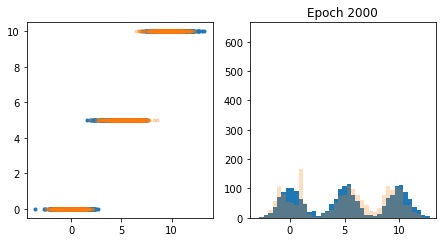

Are the D gradients small?  Variable containing:
 0.1894
-0.0221
[torch.FloatTensor of size 2]

Is the G loss small?  Variable containing:
 0.4013
[torch.FloatTensor of size 1]

Epoch #51: Generative Loss: 0.17192697525, Discriminative Loss: -0.222392082214
Difference in generated values for the two means:  [ 0.48328775  0.        ] [ 4.96142244  5.        ]


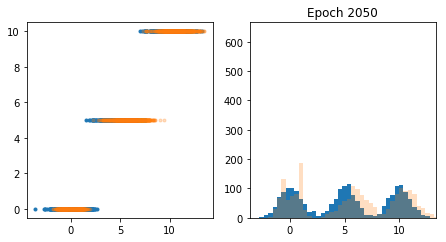

Are the D gradients small?  Variable containing:
 0.0617
 0.2765
[torch.FloatTensor of size 2]

Is the G loss small?  Variable containing:
 0.1046
[torch.FloatTensor of size 1]

Epoch #101: Generative Loss: 0.245328426361, Discriminative Loss: -0.242856264114
Difference in generated values for the two means:  [ 0.30993322  0.        ] [ 4.46630239  5.        ]


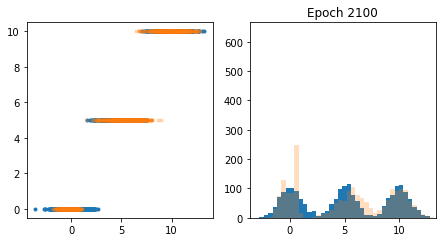

Are the D gradients small?  Variable containing:
 0.0720
 0.3195
[torch.FloatTensor of size 2]

Is the G loss small?  Variable containing:
 0.4650
[torch.FloatTensor of size 1]

Epoch #151: Generative Loss: 0.275666713715, Discriminative Loss: -0.20367193222
Difference in generated values for the two means:  [ 0.37700498  0.        ] [ 4.87052441  5.        ]


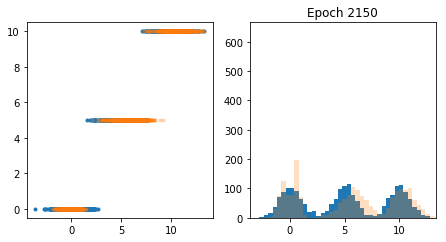

Are the D gradients small?  Variable containing:
 0.0570
 0.3658
[torch.FloatTensor of size 2]

Is the G loss small?  Variable containing:
 0.5131
[torch.FloatTensor of size 1]

Epoch #201: Generative Loss: 0.529258191586, Discriminative Loss: -0.490218162537
Difference in generated values for the two means:  [ 0.09896801  0.        ] [ 4.60891962  5.        ]


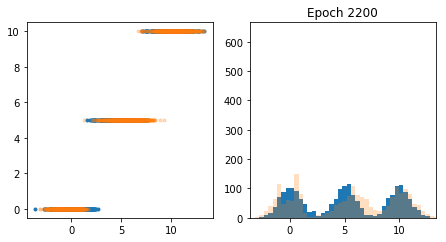

Are the D gradients small?  Variable containing:
 0.2490
 0.4940
[torch.FloatTensor of size 2]

Is the G loss small?  Variable containing:
 0.5569
[torch.FloatTensor of size 1]

Epoch #251: Generative Loss: 0.819659948349, Discriminative Loss: -0.737276315689
Difference in generated values for the two means:  [ 0.83810574  0.        ] [ 5.13701391  5.        ]


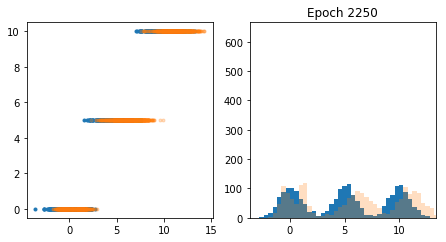

Are the D gradients small?  Variable containing:
 0.0407
 0.5074
[torch.FloatTensor of size 2]

Is the G loss small?  Variable containing:
 0.4831
[torch.FloatTensor of size 1]

Epoch #301: Generative Loss: 0.522487878799, Discriminative Loss: -0.747740626335
Difference in generated values for the two means:  [ 0.43059987  0.        ] [ 5.12963247  5.        ]


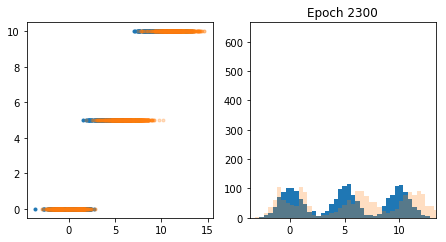

Are the D gradients small?  Variable containing:
 0.0693
 0.3918
[torch.FloatTensor of size 2]

Is the G loss small?  Variable containing:
 1.3244
[torch.FloatTensor of size 1]

Epoch #351: Generative Loss: 0.046856880188, Discriminative Loss: -0.117732524872
Difference in generated values for the two means:  [ 0.38698161  0.        ] [ 5.09633207  5.        ]


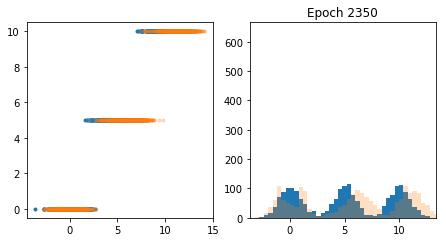

Are the D gradients small?  Variable containing:
 0.7028
 0.3186
[torch.FloatTensor of size 2]

Is the G loss small?  Variable containing:
 0.3067
[torch.FloatTensor of size 1]

Epoch #401: Generative Loss: -0.203465223312, Discriminative Loss: -0.152851104736
Difference in generated values for the two means:  [ 0.48985428  0.        ] [ 4.54372549  5.        ]


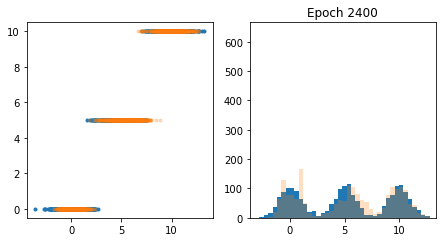

Is the G loss small?  Variable containing:
 0.4383
[torch.FloatTensor of size 1]

Are the D gradients small?  Variable containing:
 0.0448
 0.3945
[torch.FloatTensor of size 2]

Epoch #451: Generative Loss: 0.66252040863, Discriminative Loss: -0.667796134949
Difference in generated values for the two means:  [ 0.16457614  0.        ] [ 3.95848703  5.        ]


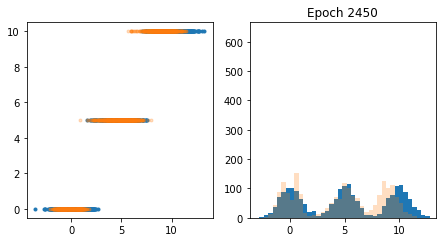

Are the D gradients small?  Variable containing:
 0.0925
 0.3750
[torch.FloatTensor of size 2]

Is the G loss small?  Variable containing:
 0.4914
[torch.FloatTensor of size 1]

Epoch #501: Generative Loss: 0.610245287418, Discriminative Loss: -0.640178263187
Difference in generated values for the two means:  [-0.030057  0.      ] [ 3.52779317  5.        ]


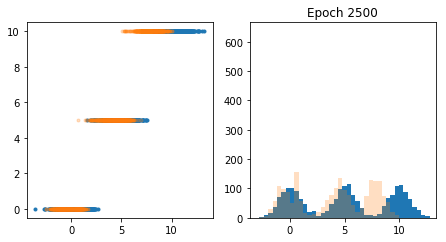

Are the D gradients small?  Variable containing:
 0.1292
-0.1591
[torch.FloatTensor of size 2]

Is the G loss small?  Variable containing:
 0.6018
[torch.FloatTensor of size 1]

Epoch #551: Generative Loss: -0.0241361856461, Discriminative Loss: -0.695351600647
Difference in generated values for the two means:  [ 0.17135322  0.        ] [ 4.52882624  5.        ]


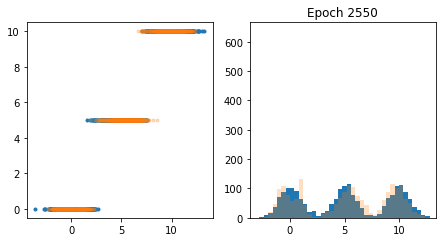

Are the D gradients small?  Variable containing:
 0.1802
 0.4360
[torch.FloatTensor of size 2]

Is the G loss small?  Variable containing:
 0.2411
[torch.FloatTensor of size 1]

Epoch #601: Generative Loss: 0.715658903122, Discriminative Loss: -0.821162939072
Difference in generated values for the two means:  [ 0.56185055  0.        ] [ 5.48426771  5.        ]


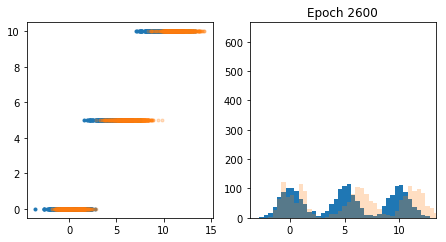

Are the D gradients small?  Variable containing:
 0.2151
 0.5307
[torch.FloatTensor of size 2]

Is the G loss small?  Variable containing:
 0.6406
[torch.FloatTensor of size 1]

Epoch #651: Generative Loss: 0.398834705353, Discriminative Loss: -0.231266856194
Difference in generated values for the two means:  [ 0.23620237  0.        ] [ 4.47065258  5.        ]


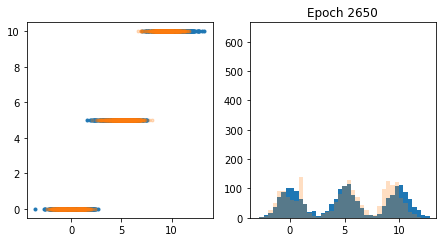

Are the D gradients small?  Variable containing:
 0.3445
-0.1287
[torch.FloatTensor of size 2]

Is the G loss small?  Variable containing:
 0.5405
[torch.FloatTensor of size 1]

Epoch #701: Generative Loss: 0.34551024437, Discriminative Loss: -0.225495219231
Difference in generated values for the two means:  [ 0.09977145  0.        ] [ 3.46755314  5.        ]


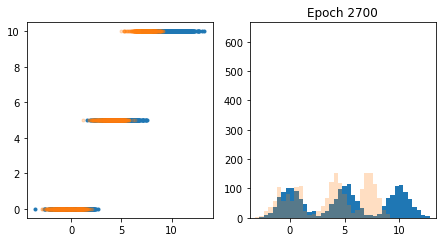

Are the D gradients small?  Variable containing:
 0.2275
 0.2402
[torch.FloatTensor of size 2]

Is the G loss small?  Variable containing:
 0.6094
[torch.FloatTensor of size 1]

Epoch #751: Generative Loss: 1.241574049, Discriminative Loss: -1.08964145184
Difference in generated values for the two means:  [ 0.90026236  0.        ] [ 6.18183708  5.        ]


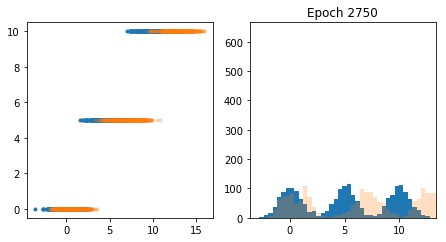

Is the G loss small?  Variable containing:
 0.9590
[torch.FloatTensor of size 1]

Are the D gradients small?  Variable containing:
 0.0094
-0.2860
[torch.FloatTensor of size 2]

Epoch #801: Generative Loss: 1.35163247585, Discriminative Loss: -1.20601546764
Difference in generated values for the two means:  [ 0.12366715  0.        ] [ 3.45332885  5.        ]


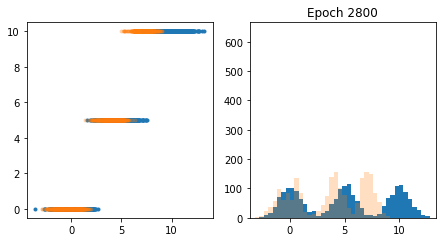

Are the D gradients small?  Variable containing:
 0.6626
-0.2487
[torch.FloatTensor of size 2]

Is the G loss small?  Variable containing:
 1.5949
[torch.FloatTensor of size 1]

Epoch #851: Generative Loss: 0.777754187584, Discriminative Loss: -1.57374763489
Difference in generated values for the two means:  [ 0.6211648  0.       ] [ 5.37644243  5.        ]


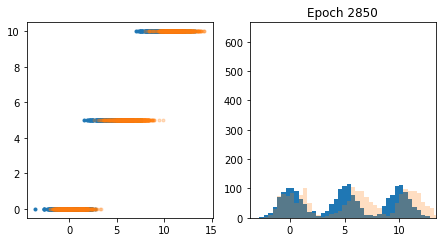

Is the G loss small?  Variable containing:
 0.4330
[torch.FloatTensor of size 1]

Are the D gradients small?  Variable containing:
1.00000e-02 *
  0.1224
 -7.9465
[torch.FloatTensor of size 2]

Epoch #901: Generative Loss: 0.260533571243, Discriminative Loss: -0.555950939655
Difference in generated values for the two means:  [ 0.3052367  0.       ] [ 4.12991571  5.        ]


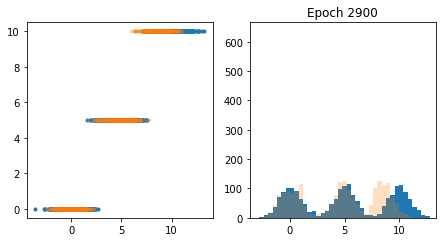

Are the D gradients small?  Variable containing:
 0.5708
-0.2286
[torch.FloatTensor of size 2]

Is the G loss small?  Variable containing:
 0.4215
[torch.FloatTensor of size 1]

Epoch #951: Generative Loss: 0.323024511337, Discriminative Loss: -0.0692245960236
Difference in generated values for the two means:  [ 0.2434684  0.       ] [ 3.90843153  5.        ]


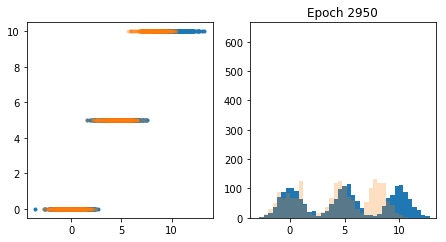

Is the G loss small?  Variable containing:
 0.2072
[torch.FloatTensor of size 1]

Are the D gradients small?  Variable containing:
 0.0447
 0.5526
[torch.FloatTensor of size 2]



In [188]:

objective = objective_wgan if wgan else objective_gan

iter_range = range(n_iterations)

#print out time information if verbose is True
#if verbose:
#    iter_range = tqdm(iter_range)

Print_Dgrad = True
Print_Gloss = True

for iteration in iter_range:
    for extra in range(extraD):
        
        real, means, both_real = sample_real(bs, shape, conditional_means)
        #both_real = 2*(both_real - torch.min(both_real))/(torch.max(both_real) - torch.min(both_real)) - 1
        noise, noise_and_means = sample_noise(bs, 1, conditional_means)
        gen_input = torch.cat((noise,means), 1)
        #gen_input = 2*(gen_input - torch.min(gen_input))/(torch.max(gen_input) - torch.min(gen_input)) - 1
        fake = netG(gen_input)
        fake_disc_input = torch.cat((fake,means),1)

        optD.zero_grad()
        lossD = objective(netD(both_real), netD(fake_disc_input))
        #print lossD
        gradD = grad(lossD * bs, fake_disc_input, create_graph=True)[0]
            
        # ALL the gradients are so small, WHYYYYYYY. Just print one for example
        if Print_Dgrad == True:
            if gradD[0][0].data.numpy() > 0.0001:
                print "Are the D gradients small? ", gradD[0]
                Print_Dgrad = False
            
        reguD = gradD.norm(2, 1).clamp(1).mean()
        (lossD + lamD * reguD).backward()
        optD.step()

    real, means, both_real = sample_real(bs, shape, conditional_means)
    # if you want to normalize: 
    # both_real = 2*(both_real - torch.min(both_real))/(torch.max(both_real) - torch.min(both_real)) - 1
    noise, noise_and_means = sample_noise(bs, 1, conditional_means)
    gen_input = torch.cat((noise,means), 1)
    #gen_input = 2*(gen_input - torch.min(gen_input))/(torch.max(gen_input) - torch.min(gen_input)) - 1
    fake = netG(gen_input)
    fake_disc_input = torch.cat((fake,means),1)
    
    optG.zero_grad()
    lossG = - objective(netD(both_real), netD(fake_disc_input))
    
    # ALL the gradients are so small, WHYYYYYYY. Just print one for example
    if Print_Gloss == True:
        if lossG.data.numpy() > 0.0001:
            print "Is the G loss small? ", lossG
            Print_Gloss = False
            
    (lossG).backward()
    optG.step()

    if (iteration % v_freq) == 0:
        #print "Iteration: " iteration, "Discriminative Loss: " lossD.data[0], 
              #"Generative Loss: " lossG.data[0], reguD.data[0]
        print("Epoch #{}: Generative Loss: {}, Discriminative Loss: {}".format(iteration + 1, lossG.data[0], lossD.data[0]))
        Print_Dgrad, Print_Gloss = True, True
        p_both_fake = torch.cat((netG(torch.cat((p_nois,p_means),1)),p_means),1)
        #p_both_fake = Variable(torch.FloatTensor(np.column_stack((netG(p_nois).data.numpy(), p_means.data.numpy()))), requires_grad = True)
        plot(p_both_real, p_both_fake, iteration)

# UNCOMMENT IF YOU WANT TO MAKE A SEQUENTIAL GIF OF ALL THE LITTLE PLOTS
# if MakeGif == True:
#     png_dir = "./plots/GIFTest/"
#     images = []
#     for subdir, dirs, files in os.walk(png_dir):
#         for file in files:
#             file_path = os.path.join(subdir, file)
#             if file_path.endswith(".png"):
#                 images.append(imageio.imread(file_path))
#     imageio.mimsave('./plots/GIFTest/CWGANTestGaussianToGaussian3Mean3layer40nodesPerLayer2000epochlamD35extraD50.gif', images)



In [174]:
means_string = ""
for digit in conditional_means:
    means_string+= '-' + str(digit)
    
means_string

'-0-5-10'

'plots/GeneratedNormalConditionalSampleFromGaussNoise_LinearReLUPerceptronWCGAN_4Layers_20hiddenPerLayer_10BatchSize_8001Epochs_50LambPenalty_15ExtraD_Means-0-5-10'

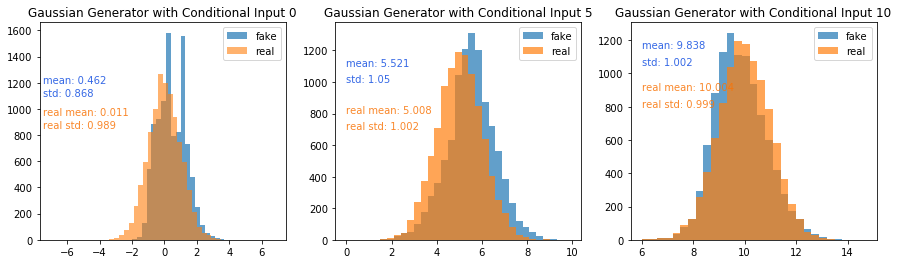

In [210]:

real_vals0, means0, both_real0 = sample_real(10000, shape, [0])
real_vals1, means1, both_real1 = sample_real(10000, shape, [5])
real_vals2, means2, both_real2 = sample_real(10000, shape, [10])
output0 = netG(torch.cat((sample_noise(10000, [0])[0], means0), 1))
output1 = netG(torch.cat((sample_noise(10000, [5])[0], means1), 1))
output2 = netG(torch.cat((sample_noise(10000, [10])[0], means2), 1))
fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, figsize=(15,4))
ax1.hist(output0.data.numpy(), alpha=0.7, bins = np.arange(-5, 5, 0.3), label = 'fake')
ax1.hist(real_vals0.data.numpy(), alpha=0.6, bins = np.arange(-7, 7, 0.3), label = 'real')
ax2.hist(output1.data.numpy(), alpha = 0.7, bins = np.arange(0, 10, 0.3), label = 'fake')
ax2.hist(real_vals1.data.numpy(), alpha = 0.7, bins = np.arange(0, 10, 0.3), label = 'real')
ax3.hist(output2.data.numpy(), alpha = 0.7, bins = np.arange(6, 15, 0.3), label = 'fake')
ax3.hist(real_vals2.data.numpy(), alpha = 0.7, bins = np.arange(6, 15, 0.3), label = 'real')
ax1.set_title("Gaussian Generator with Conditional Input 0")
ax1.legend(loc='upper right')
ax2.set_title("Gaussian Generator with Conditional Input 5")
ax2.legend(loc='upper right')
ax3.set_title("Gaussian Generator with Conditional Input 10")
ax3.legend(loc='upper right')

ax1.text(-7.5, 1200, 'mean: ' + str(output0.data.numpy().mean().round(3)), fontsize = 10, alpha = 0.8, color = 'xkcd:blue')
ax1.text(-7.5, 1100, 'std: ' + str(output0.data.numpy().std().round(3)), fontsize = 10, alpha = 0.8, color = 'xkcd:blue')
ax1.text(-7.5, 950, 'real mean: ' + str(real_vals0.data.numpy().mean().round(3)), fontsize = 10, alpha = 0.85, color = 'xkcd:orange')
ax1.text(-7.5, 850, 'real std: ' + str(real_vals0.data.numpy().std().round(3)) , fontsize = 10, alpha = 0.85, color = 'xkcd:orange')

ax2.text(0, 1100, 'mean: ' + str(output1.data.numpy().mean().round(3)), fontsize = 10, alpha = 0.8, color = 'xkcd:blue')
ax2.text(0, 1000, 'std: ' + str(output1.data.numpy().std().round(3)), fontsize = 10, alpha = 0.8, color = 'xkcd:blue')
ax2.text(0, 800, 'real mean: ' + str(real_vals1.data.numpy().mean().round(3)) , fontsize = 10, alpha = 0.85, color = 'xkcd:orange')
ax2.text(0, 700, 'real std: ' + str(real_vals1.data.numpy().std().round(3)) , fontsize = 10, alpha = 0.85, color = 'xkcd:orange')

ax3.text(6, 1150, 'mean: ' + str(output2.data.numpy().mean().round(3)), fontsize = 10, alpha = 0.8, color = 'xkcd:blue')
ax3.text(6, 1050, 'std: ' + str(output2.data.numpy().std().round(3)), fontsize = 10, alpha = 0.8, color = 'xkcd:blue')
ax3.text(6, 900, 'real mean: ' + str(real_vals2.data.numpy().mean().round(3)) , fontsize = 10, alpha = 0.85, color = 'xkcd:orange')
ax3.text(6, 800, 'real std: ' + str(real_vals2.data.numpy().std().round(3)) , fontsize = 10, alpha = 0.85, color = 'xkcd:orange')



filename = ("plots/GeneratedNormalConditionalSampleFromGaussNoise_Linear" + Layer_type + "PerceptronWCGAN_" 
            + str(n_layers) + "Layers_" + str(n_hidden) + "hiddenPerLayer_" + str(bs) 
            + "BatchSize_" + str(n_iterations) + "Epochs_" + str(int(lamD)) + "LambPenalty_" + str(extraD) + "ExtraD_Means" + str(means_string))
filename
#plt.savefig(filename)

In [176]:
str(conditional_means)

'[0, 5, 10]'

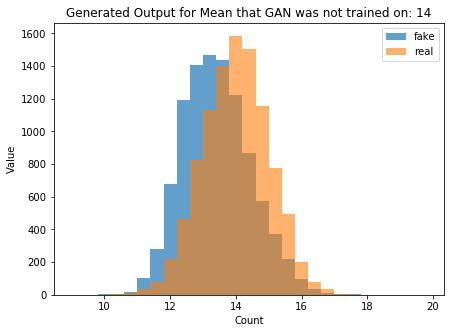

In [242]:
# Checking what happens when I try to generate values around a mean that the GAN was not trained on.

real_vals25, means25, both_real25 = sample_real(10000, shape, [14])
output25 = netG(torch.cat((sample_noise(10000, [14])[0], means25), 1))
fig = plt.figure(figsize=(7,5))
plt.hist(output25.data.numpy(), alpha=0.7, bins = np.arange(9, 20, 0.4), label = 'fake')
plt.hist(real_vals25.data.numpy(), alpha=0.6, bins = np.arange(9, 20, 0.4), label = 'real')
plt.title("Generated Output for Mean that GAN was not trained on: 14")
plt.xlabel("Count")
plt.ylabel("Value")
plt.legend(loc='best')


In [845]:
# UNCOMMENT IF YOU WANT TO MAKE A GIF OUT OF THE LITTLE PLOTS

# import os
# import imageio

# if MakeGif == True:
#     png_dir = "./plots/GIFTest/"
#     images = []
#     for subdir, dirs, files in os.walk(png_dir):
#         for file in files:
#             file_path = os.path.join(subdir, file)
#             if file_path.endswith(".png"):
#                 images.append(imageio.imread(file_path))
#     imageio.mimsave('./plots/GIFTest/GANEvolveUnif2G_bs1.gif', images)